In [1]:
import csv
import math
import os
from math import pi, isnan

import matplotlib
import numpy
import pandas
from matplotlib.patches import Rectangle

from constants import *

from only_front.test import *
from only_front.env_front_lidar import *
from matplotlib import pyplot
from matplotlib.patches import Rectangle
%matplotlib inline

pygame 2.1.3.dev8 (SDL 2.0.22, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
directory = '..\\..\\run_complex'
file_name = os.path.join(directory, 'var.npz')
report_file_name=os.path.join(directory, 'report.csv')
names = ['row','v', 'w', 't', 'alive_agent_count']


In [3]:
# W= numpy.array([1, 2, 3, 5, 10, 15, 20, 25,  30, 35, 40, 45])
# V=numpy.array(range(1, 1001))/100


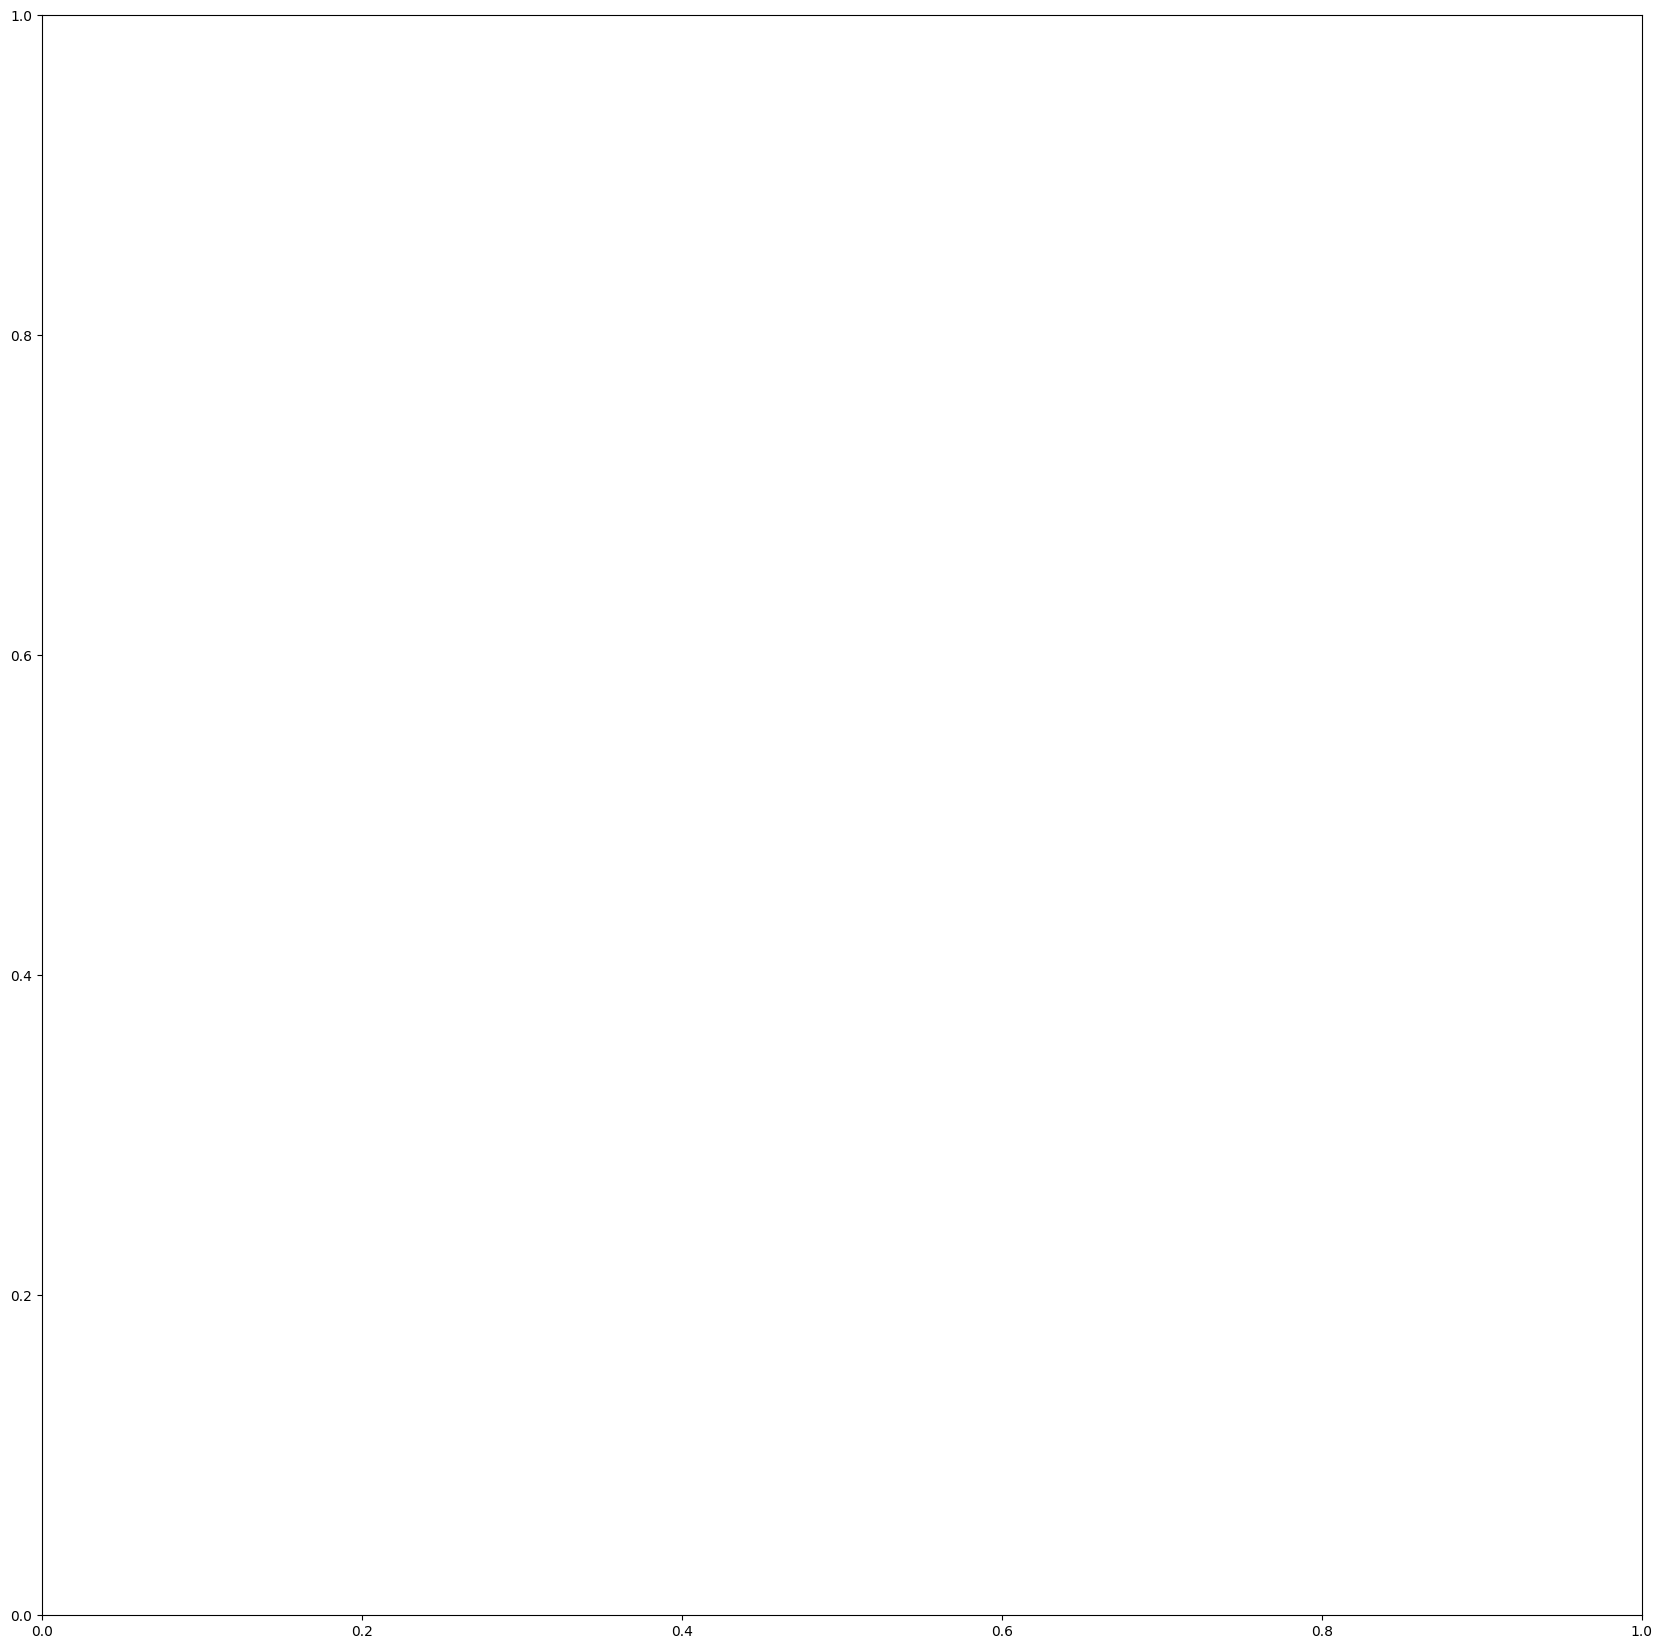

In [4]:
W= numpy.array([1, 2, 3, 5, 10, 15, 30, 45, 20])
V=numpy.array(range(1, 101))/10



if os.path.exists(report_file_name):
    df=pandas.read_csv(report_file_name, names=names, header=None,  dtype=float)
    df['row']=df['row'].astype(int)
    df_last=df.iloc[-1]
    w0i = int(numpy.where(W== df_last['w'])[0])
    v0i = int(numpy.where(V==df_last['v'])[0])+1

    run = int(df_last['row']+1)
    # df.set_index(['row'], inplace=True)
else:
    df=pandas.DataFrame(columns=names)
    # df.set_index(['row'])
    w0i=0
    v0i=0
    run = 0
N = 3
sensor_range = 20
ROBOT_RADIUS = 0.1
Dx, Dy = desiredXYSquarePattern(N, 5)
env = Env(250, 250, 210, 160, N * N, Dx, Dy, sensor_range, 20, 20, ROBOT_RADIUS, SENSOR_DETECTION_COUNT, 5000000)
    # env.addObstacle(50, 0, 60, 200)
env.addObstacle(50, 0, 60, 80)
env.addObstacle(50, 100, 60, 220)

env.addObstacle(100, 40, 220, 50)

env.addObstacle(100, 50, 110, 180)
env.addObstacle(100, 200, 110, 250)

env.addObstacle(170, 100, 180, 220)

env.addObstacle(200, 100, 250, 110)

    # env.addObstacle(50, 80, 150, 120)


fig = pyplot.figure(figsize=(16, 16))
ax = fig.add_axes([0, 0, 1, 1])
# if os.path.exists(file_name):
#     cur_state = numpy.load(file_name)
#     w0i = int(cur_state['w'])
#     v0i = int(cur_state['v'])
#     run = int(cur_state['run'])
# else:
#     w0i=0
#     v0i=0
#     run = 0

In [5]:
episode_gui(env, 1, 1)

In [ ]:
with open(report_file_name, 'a') as report_file:
    writer = csv.writer(report_file)
    # writer.writerow(row)

    for wi in range(w0i, W.size):
        w=W[wi]
        print(w)
        for vi in range(v0i,  V.size):
            v=V[vi]
            env.reset()
            env.agents[0].left=env.agents[3]
            env.agents[1].left=env.agents[0]
            env.agents[2].left=env.agents[1]
            env.agents[5].left=env.agents[2]
            env.agents[8].left=env.agents[5]
            env.agents[7].left=env.agents[8]
            env.agents[6].left=env.agents[7]
            env.agents[3].left=env.agents[6]


            env.agents[3].right= env.agents[0]
            env.agents[0].right= env.agents[1]
            env.agents[1].right= env.agents[2]
            env.agents[2].right= env.agents[5]
            env.agents[5].right= env.agents[8]
            env.agents[8].right= env.agents[7]
            env.agents[7].right= env.agents[6]
            env.agents[6].right= env.agents[3]

            for i in range(1, N-1):
                for j in range(1, N-1):
                    env.agents[i*N+j].sensored=False

            while(not env.is_done):
                env.play_step(v,w*pi/180)

            ####################################################
            ax.invert_yaxis()
            posei=env.pose_history[:, env.N, :]
            ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  zorder=3, label='Virtual Leader', color='blue')

            line=[None]*env.N

            for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')


            # ax.legend()
            for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))

            ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
            ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
            for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')
            fig.savefig(os.path.join(directory, 'run'+str(run)+'W'+str(w)+'V'+str(v)+'.jpg'), bbox_inches='tight')
            ax.clear()
            # fig.clf()
            # pyplot.clf()
            ##################################################

            env.save_episode(os.path.join(directory, 'run'+str(run)))
            alive_agent_count = N * N - numpy.sum(env.dead_history[env.t - 1, :])
            t = env.t if (equals(leader_goal_distance(env), 0.0)) else None
            # print(t)
            # print(alive_agent_count)
            row=[run, v, w, t, alive_agent_count]
            df.loc[run]=row
            print(row)



            with open(report_file_name, 'a') as report_file:
                writer=csv.writer(report_file)
                writer.writerow(row)
            numpy.savez(file_name, w=wi, run=run, v=vi)
            run+=1
        v0i=0
    w0i=0

In [8]:
# directory = '..\\..\\run_complex'
# file_name = os.path.join(directory, 'var.npz')
# report_file_name=os.path.join(directory, 'report.csv')
# names = ['row','v', 'w', 't', 'alive_agent_count']
# df=pandas.read_csv(report_file_name, names=names, header=None, dtype=float)
# df_last=df.iloc[-1]
# df_last
# int(numpy.where(W== df_last['w'])[0])
# df.loc[run]=row

In [9]:
df[df['t'].isna()]

,row,v,w,t,alive_agent_count
33,33,3.4,1.0,NaN,0.0
34,34,3.5,1.0,NaN,0.0
35,35,3.6,1.0,NaN,0.0
36,36,3.7,1.0,NaN,0.0
37,37,3.8,1.0,NaN,0.0
...,...,...,...,...,...
895,895,9.2,20.0,NaN,0.0
897,897,9.4,20.0,NaN,0.0
901,901,9.8,20.0,NaN,0.0
902,902,9.9,20.0,NaN,0.0


In [10]:
df.shape

(904, 5)

In [11]:
df=df.drop_duplicates(subset=['v', 'w'], keep='last')


In [42]:
df_to_plot_t=df[df['w']<5].pivot(index='v', columns='w', values='t')
df_to_plot_s=df.pivot(index='v', columns='w', values='alive_agent_count')

<AxesSubplot:xlabel='v'>

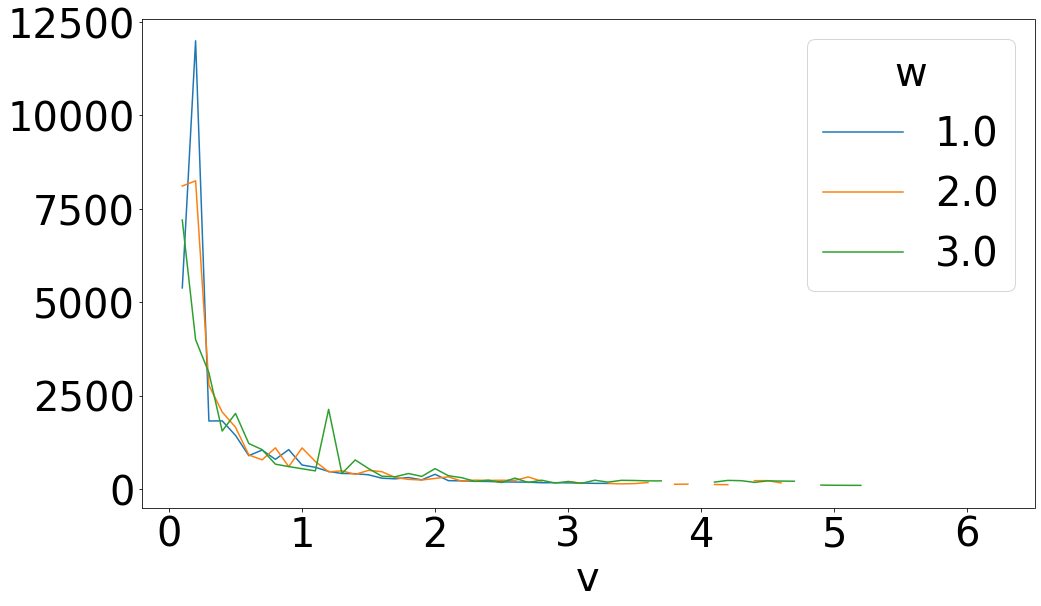

In [43]:
df_to_plot_t.plot(figsize=(16, 9))

<AxesSubplot:xlabel='v'>

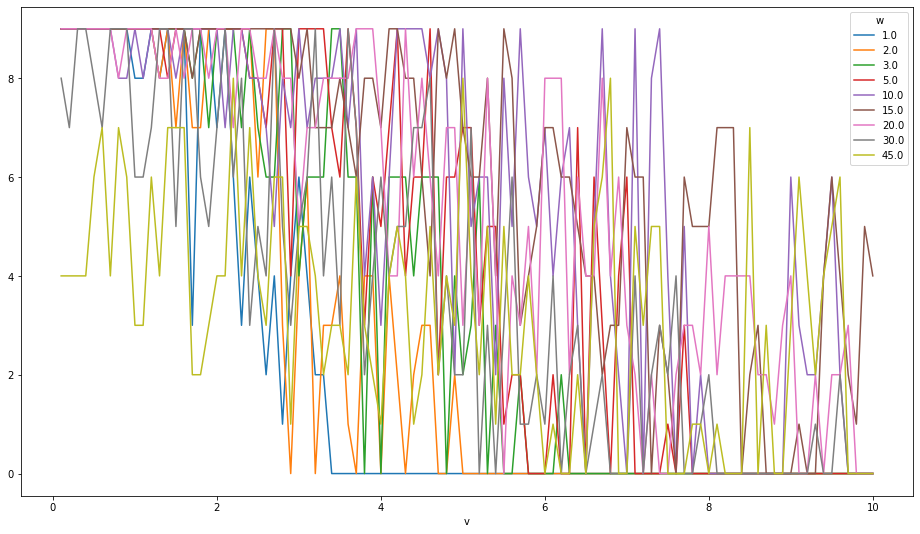

In [14]:
df_to_plot_s.plot(figsize=(16, 9))

<AxesSubplot:xlabel='v'>

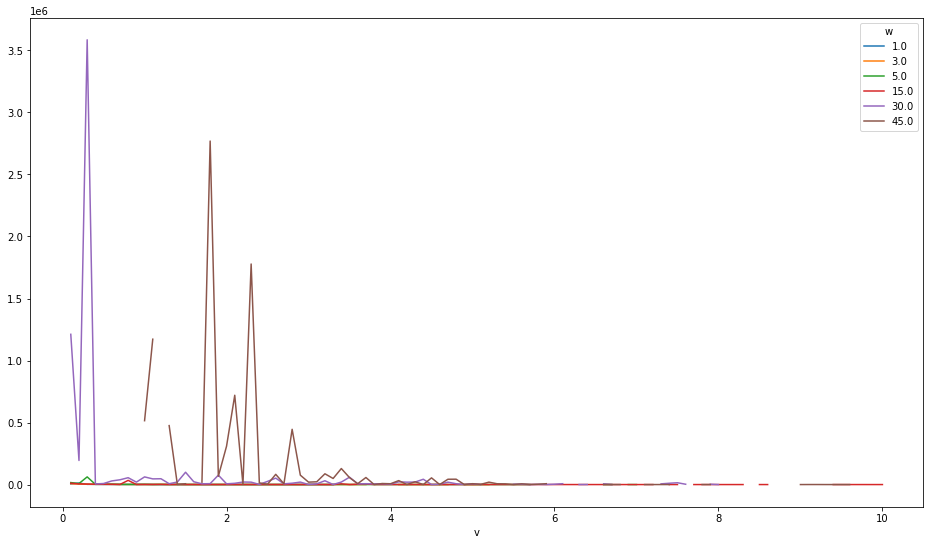

In [15]:

df1=df[df['w'].isin([1, 3, 5, 15, 30, 45])] #df[df['w']!=60  ][df['w']!=45 ][df['w']!=30][df['w']!=1]
df_to_plot_t=df1.pivot(index='v', columns='w', values='t')
df_to_plot_s=df1.pivot(index='v', columns='w', values='alive_agent_count')



df_to_plot_t.plot(figsize=(16, 9))

Text(0.5, 1.0, 'w=45')

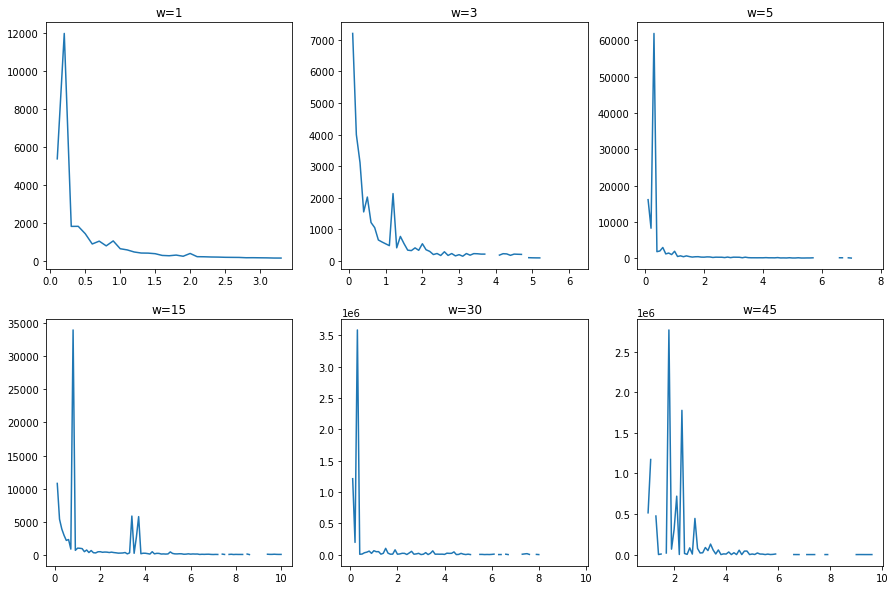

In [16]:
fig, axs= pyplot.subplots(2, 3, figsize=(15,10))#1 3 -5 15 30 45
axs[0, 0].plot(df_to_plot_t.index, df_to_plot_t[1])
axs[0, 0].set_title('w=1')

axs[0, 1].plot(df_to_plot_t.index, df_to_plot_t[3])
axs[0, 1].set_title('w=3')

axs[0, 2].plot(df_to_plot_t.index, df_to_plot_t[5])
axs[0, 2].set_title('w=5')

axs[1, 0].plot(df_to_plot_t.index, df_to_plot_t[15])
axs[1, 0].set_title('w=15')

axs[1, 1].plot(df_to_plot_t.index, df_to_plot_t[30])
axs[1, 1].set_title('w=30')

axs[1, 2].plot(df_to_plot_t.index, df_to_plot_t[45])
axs[1, 2].set_title('w=45')






Text(0.5, 1.0, 'w=45')

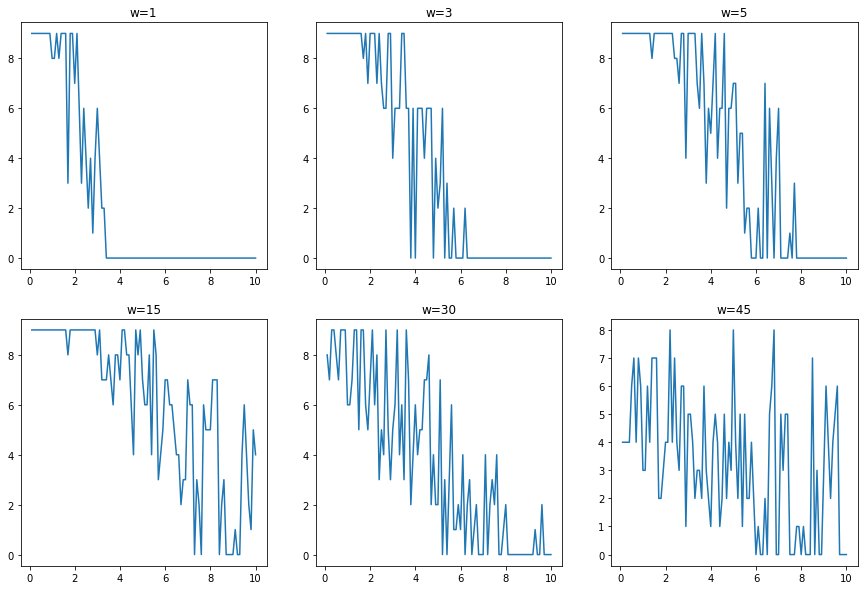

In [17]:
fig, axs= pyplot.subplots(2, 3, figsize=(15,10))#1 3 5 15 30 45
axs[0, 0].plot(df_to_plot_s.index, df_to_plot_s[1])
axs[0, 0].set_title('w=1')

axs[0, 1].plot(df_to_plot_s.index, df_to_plot_s[3])
axs[0, 1].set_title('w=3')

axs[0, 2].plot(df_to_plot_s.index, df_to_plot_s[5])
axs[0, 2].set_title('w=5')

axs[1, 0].plot(df_to_plot_s.index, df_to_plot_s[15])
axs[1, 0].set_title('w=15')

axs[1, 1].plot(df_to_plot_s.index, df_to_plot_s[30])
axs[1, 1].set_title('w=30')

axs[1, 2].plot(df_to_plot_s.index, df_to_plot_s[45])
axs[1, 2].set_title('w=45')

In [18]:
df_to_plot_t.index

Float64Index([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1.0,  1.1,
               1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2.0,  2.1,  2.2,
               2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3.0,  3.1,  3.2,  3.3,
               3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4.0,  4.1,  4.2,  4.3,  4.4,
               4.5,  4.6,  4.7,  4.8,  4.9,  5.0,  5.1,  5.2,  5.3,  5.4,  5.5,
               5.6,  5.7,  5.8,  5.9,  6.0,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
               6.7,  6.8,  6.9,  7.0,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
               7.8,  7.9,  8.0,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
               8.9,  9.0,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
              10.0],
             dtype='float64', name='v')

In [19]:
df_null=df[df['t'].isna()]
df_null

,row,v,w,t,alive_agent_count
33,33,3.4,1.0,NaN,0.0
34,34,3.5,1.0,NaN,0.0
35,35,3.6,1.0,NaN,0.0
36,36,3.7,1.0,NaN,0.0
37,37,3.8,1.0,NaN,0.0
...,...,...,...,...,...
895,895,9.2,20.0,NaN,0.0
897,897,9.4,20.0,NaN,0.0
901,901,9.8,20.0,NaN,0.0
902,902,9.9,20.0,NaN,0.0


FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\run_simple\\report.csv'

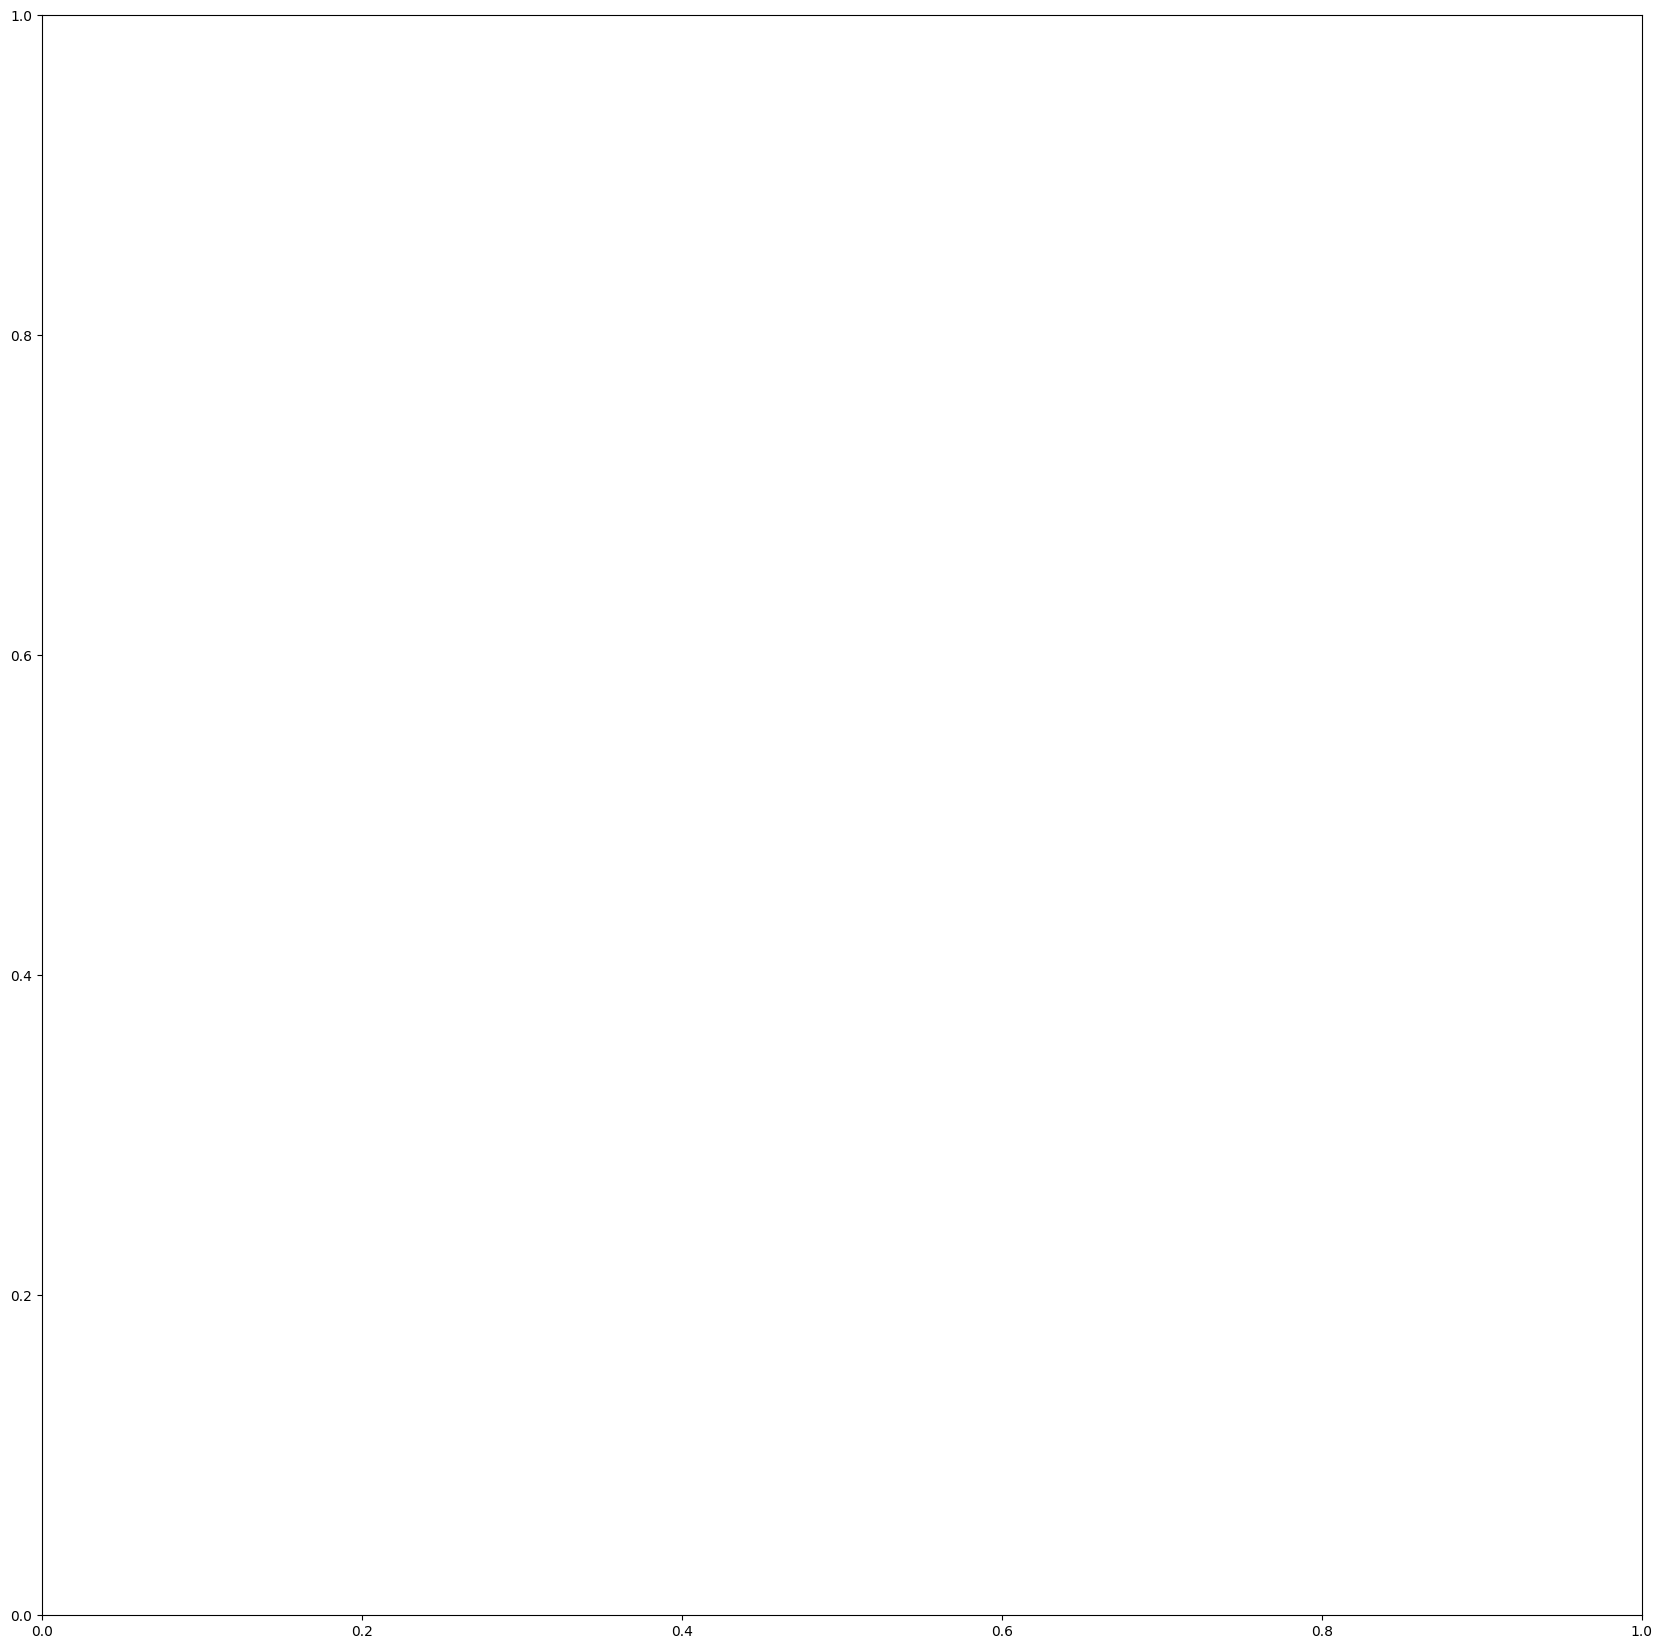

In [6]:
W= numpy.array([1, 2, 3, 5, 10, 15, 30, 45, 20])
V=numpy.array(range(1, 101))/10
directory = '..\\..\\run_simple'
file_name = os.path.join(directory, 'var.npz')
report_file_name=os.path.join(directory, 'report.csv')
names = ['row','v', 'w', 't', 'alive_agent_count']

if os.path.exists(report_file_name):
    df_=pandas.read_csv(report_file_name, names=names, header=None,  dtype=float)
    df_['row']=df_['row'].astype(int)
    df_last=df_.iloc[-1]
    w0i = int(numpy.where(W== df_last['w'])[0])
    v0i = int(numpy.where(V==df_last['v'])[0])+1

    run = int(df_last['row']+1)
    # df_.set_index(['row'], inplace=True)
else:
    w0i=0
    v0i=0
    run = 0
    df_=pandas.DataFrame(columns=names)

    # df_.set_index(['row'], inplace=True)
N = 3
sensor_range = 20
ROBOT_RADIUS = 0.3
Dx, Dy = desiredXYSquarePattern(N, 5)
env = Env(250, 250, 125, 220, N * N, Dx, Dy, sensor_range, 125, 20, ROBOT_RADIUS, SENSOR_DETECTION_COUNT, 5000000)
env.addObstacle(100, 70, 150, 100)

env.addObstacle(50, 130, 100, 170)
env.addObstacle(150, 130, 200, 170)

    # env.addObstacle(50, 80, 150, 120)


fig = pyplot.figure(figsize=(16, 16))
ax = fig.add_axes([0, 0, 1, 1])
with open(report_file_name, 'a') as report_file:
    writer = csv.writer(report_file)
    # writer.writerow(row)

    for wi in range(w0i, W.size):
        w=W[wi]
        print(w)
        for vi in range(v0i,  V.size):
            v=V[vi]
            env.reset()
            env.agents[0].left=env.agents[3]
            env.agents[1].left=env.agents[0]
            env.agents[2].left=env.agents[1]
            env.agents[5].left=env.agents[2]
            env.agents[8].left=env.agents[5]
            env.agents[7].left=env.agents[8]
            env.agents[6].left=env.agents[7]
            env.agents[3].left=env.agents[6]


            env.agents[3].right= env.agents[0]
            env.agents[0].right= env.agents[1]
            env.agents[1].right= env.agents[2]
            env.agents[2].right= env.agents[5]
            env.agents[5].right= env.agents[8]
            env.agents[8].right= env.agents[7]
            env.agents[7].right= env.agents[6]
            env.agents[6].right= env.agents[3]

            for i in range(1, N-1):
                for j in range(1, N-1):
                    env.agents[i*N+j].sensored=False
            while(not env.is_done):
                env.play_step(v,w*pi/180)
        ####################################################

            ax.invert_yaxis()
            posei=env.pose_history[:, env.N, :]
            ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)

            line=[None]*env.N

            for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')


            # ax.legend()
            for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))

            ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
            ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
            for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')
            fig.savefig(os.path.join(directory, 'run'+str(run)+'W'+str(w)+'V'+str(v)+'.jpg'), bbox_inches='tight')
            ax.clear()
            # fig.clf()
            # pyplot.clf()
            ##################################################
            env.save_episode(os.path.join(directory, 'run'+str(run)))
            alive_agent_count = N * N - numpy.sum(env.dead_history[env.t - 1, :])
            t = env.t if (equals(leader_goal_distance(env), 0.0)) else None
            # print(t)
            # print(alive_agent_count)
            row=[run, v, w, t, alive_agent_count]
            df_.loc[run]=row
            print(row)
            with open(report_file_name, 'a') as report_file:
                writer=csv.writer(report_file)
                writer.writerow(row)
            numpy.savez(file_name, w=wi, run=run, v=vi)
            run+=1
        v0i=0
    w0i=0

In [7]:
episode_gui(env, 1, 1)

KeyboardInterrupt: 

In [21]:
df_to_plot_t_=df_.pivot(index='v', columns='w', values='t')
df_to_plot_s_=df_.pivot(index='v', columns='w', values='alive_agent_count')
# df1=df[df['w'].isin([1, 3, 5, 15, 30, 45])] #df[df['w']!=60  ][df['w']!=45 ][df['w']!=30][df['w']!=1]
df_to_plot_t=df.pivot(index='v', columns='w', values='t')
df_to_plot_s=df.pivot(index='v', columns='w', values='alive_agent_count')

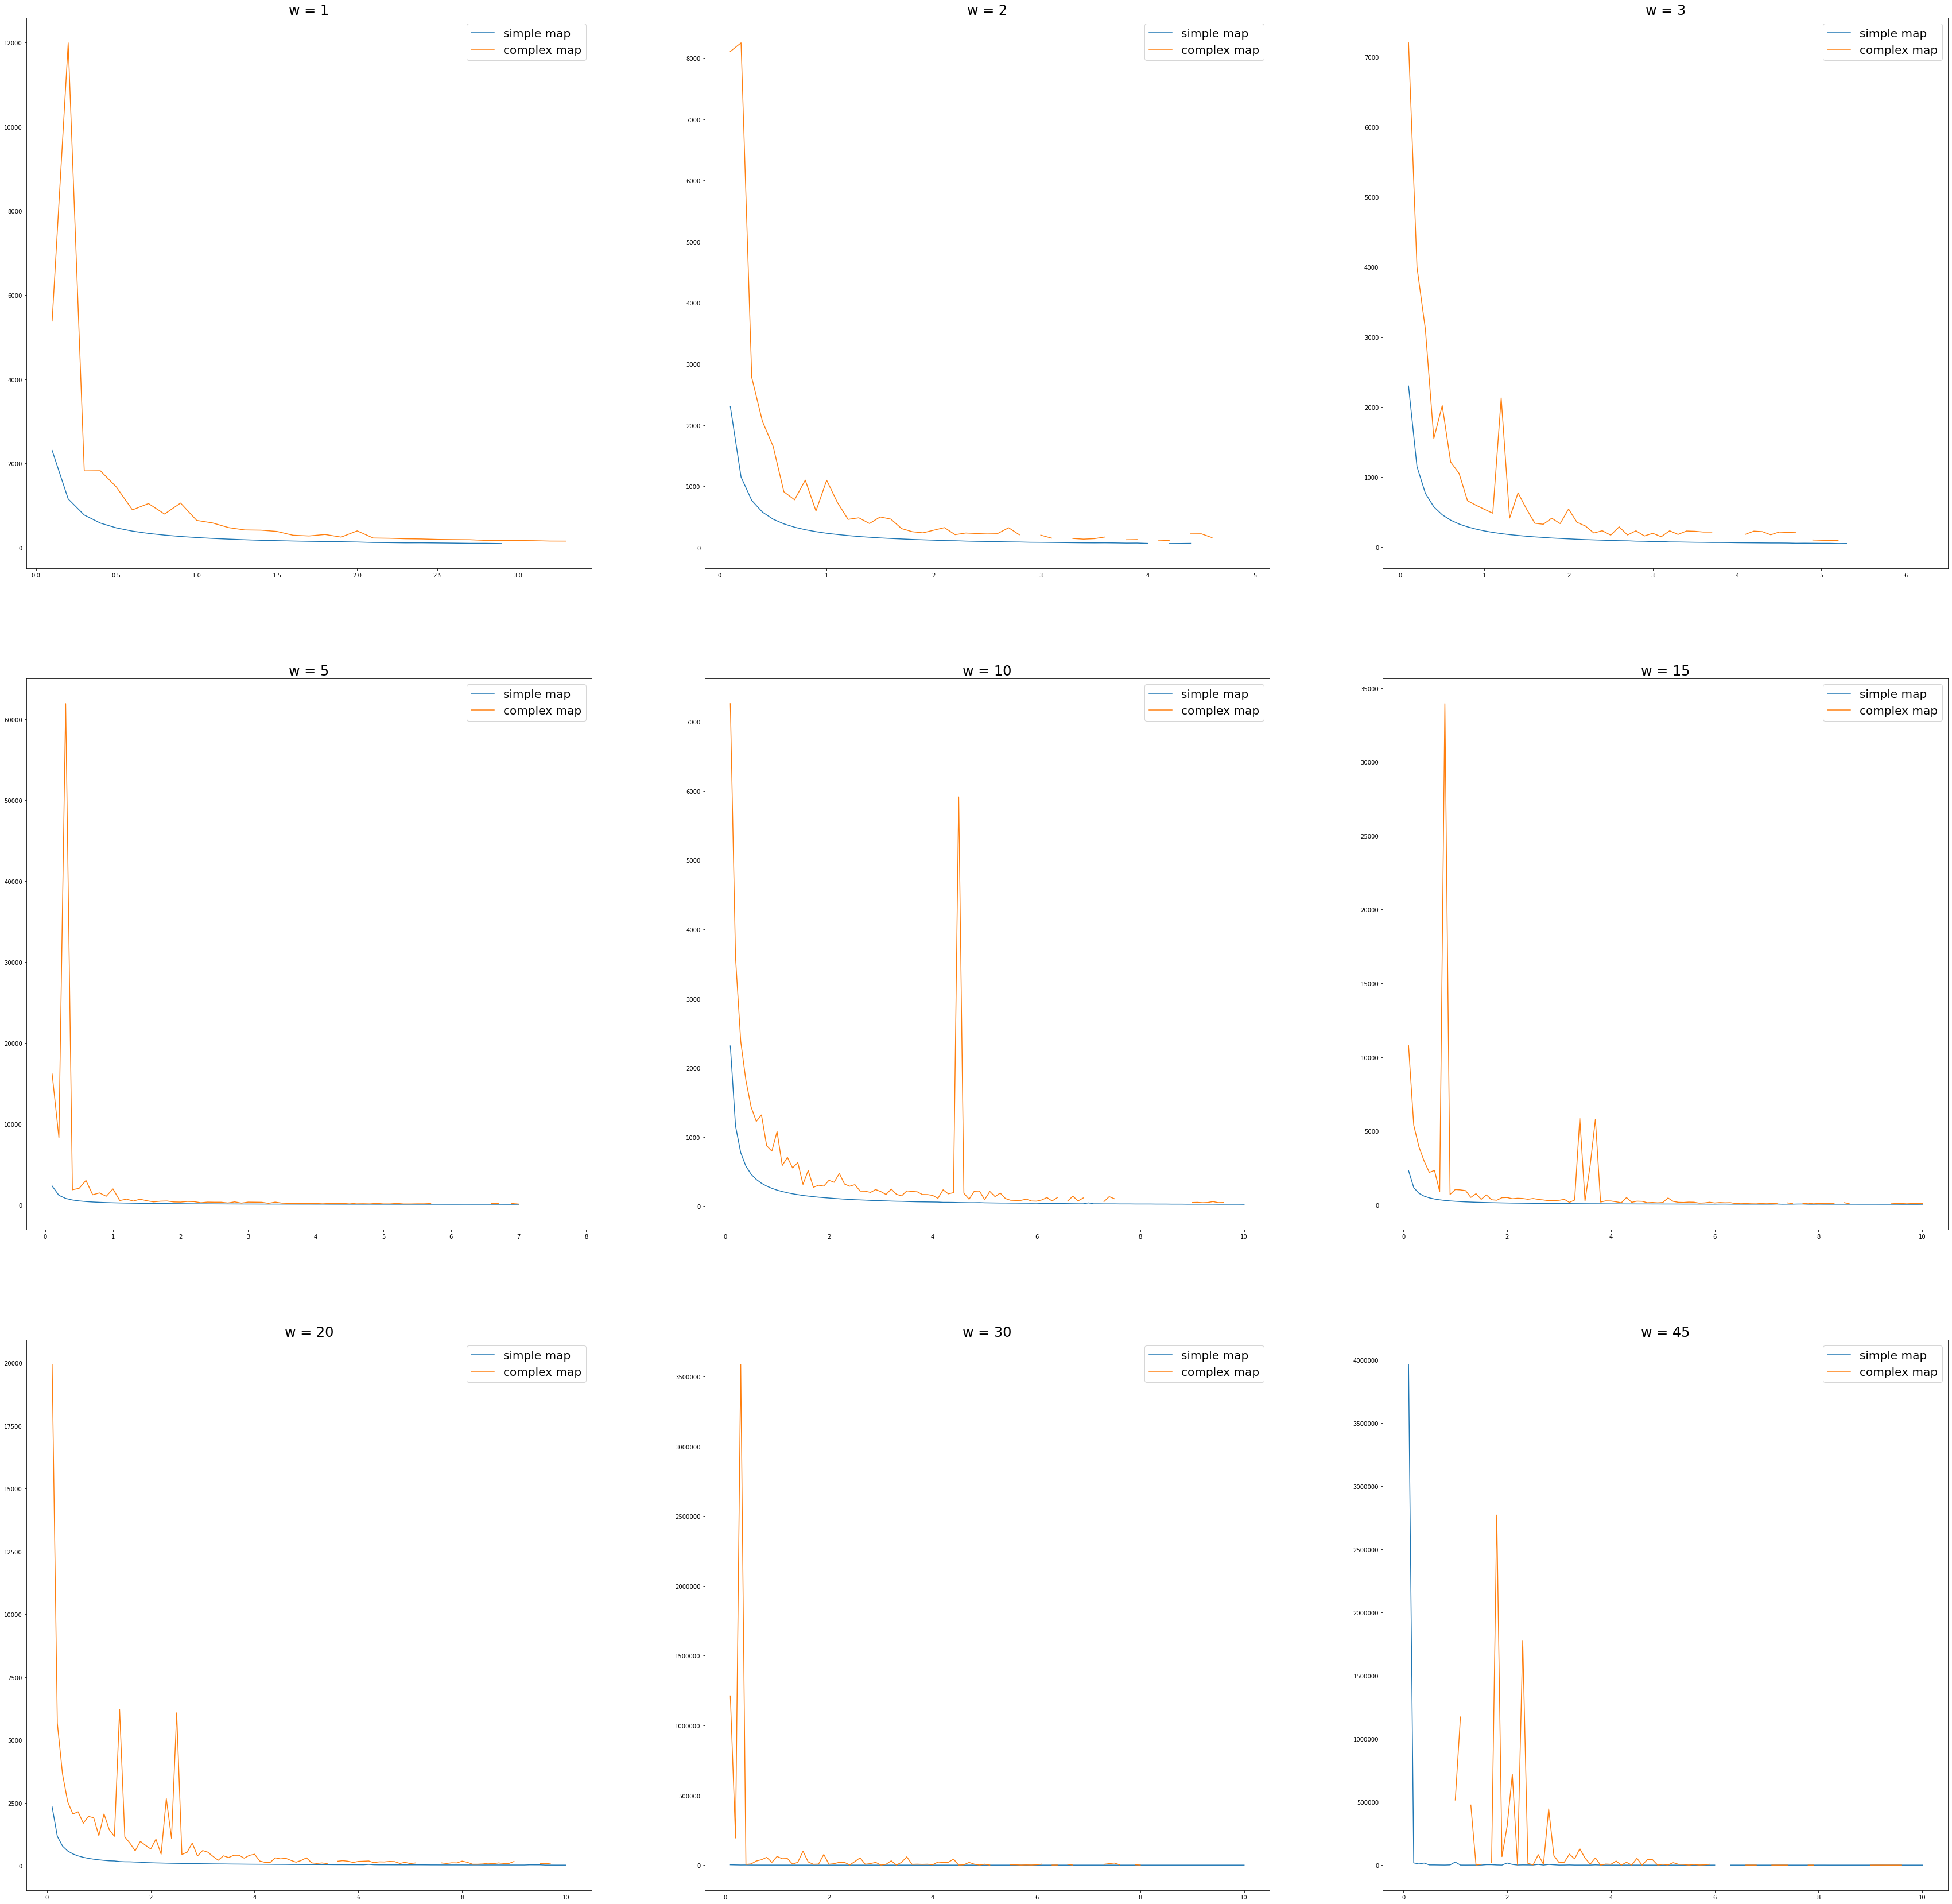

In [22]:
fig, axs= pyplot.subplots(3, 3, figsize=(60, 60))#1 3 5 15 30 45
matplotlib.rc('font', size=20)
w=1
axs[0, 0].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[0, 0].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[0, 0].legend()
axs[0, 0].set_title('w = '+str(w))

w=2
axs[0, 1].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[0, 1].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[0, 1].set_title('w = '+str(w))
axs[0, 1].legend()

w=3
axs[0, 2].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[0, 2].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[0, 2].set_title('w = '+str(w))
axs[0, 2].legend()

w=5
axs[1, 0].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[1, 0].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[1, 0].set_title('w = '+str(w))
axs[1, 0].legend()

w=10
axs[1, 1].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[1, 1].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[1, 1].set_title('w = '+str(w))
axs[1, 1].legend()

w=15
axs[1, 2].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[1, 2].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[1, 2].set_title('w = '+str(w))
axs[1, 2].legend()


w=20
axs[2, 0].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[2, 0].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[2, 0].set_title('w = '+str(w))
axs[2, 0].legend()

w=30
axs[2, 1].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[2, 1].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[2, 1].set_title('w = '+str(w))
axs[2, 1].legend()
axs[2, 1].get_yaxis().get_major_formatter().set_scientific(False)

w=45
axs[2, 2].plot(df_to_plot_t_.index, df_to_plot_t_[w], label='simple map')
axs[2, 2].plot(df_to_plot_t.index, df_to_plot_t[w], label='complex map')
axs[2, 2].set_title('w = '+str(w))
axs[2, 2].get_yaxis().get_major_formatter().set_scientific(False)
axs[2, 2].legend()

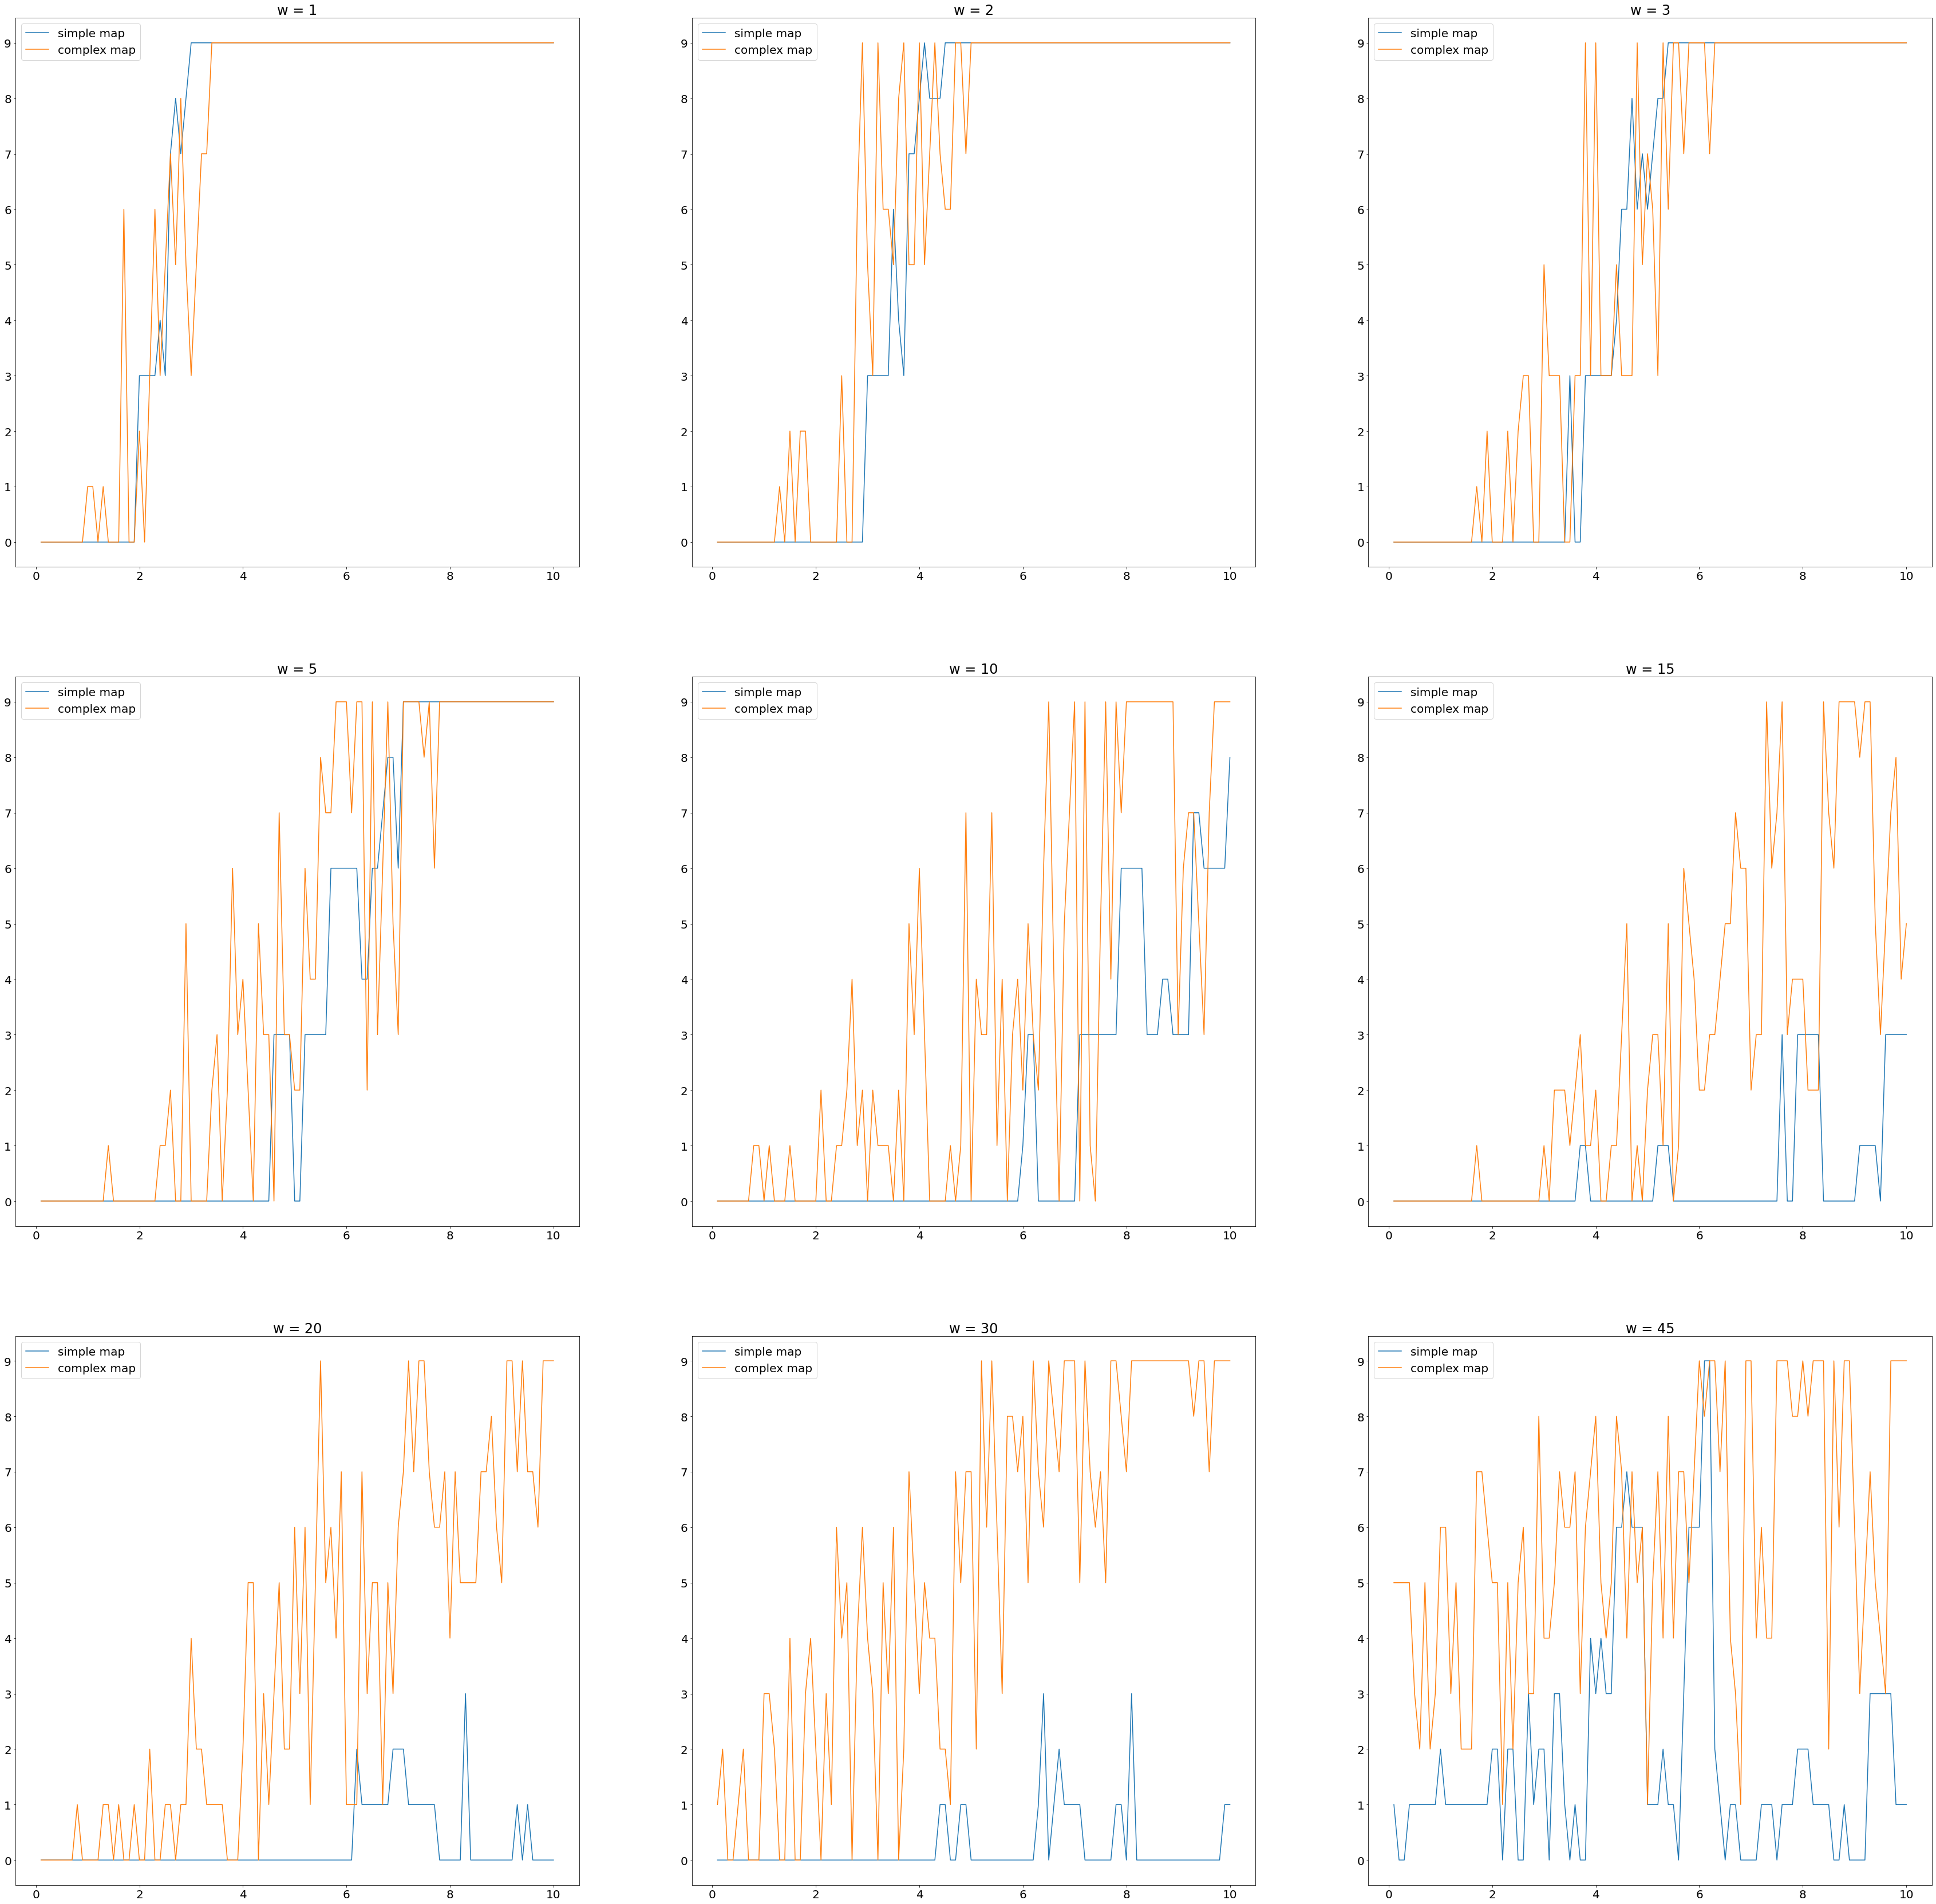

In [23]:
from matplotlib.ticker import MaxNLocator

df_to_plot_s_=9-df_to_plot_s_
df_to_plot_s=9-df_to_plot_s

fig, axs= pyplot.subplots(3, 3, figsize=(60,60))#1 3 5 15 30 45
matplotlib.rc('font', size=20)

w=1
ax=axs[0, 0]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

w=2
ax=axs[0, 1]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

w=3
ax=axs[0, 2]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


w=5
ax=axs[1, 0]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))



w=10
ax=axs[1, 1]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

w=15
ax=axs[1, 2]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


w=20
ax=axs[2, 0]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))



w=30
ax=axs[2, 1]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

w=45
ax=axs[2, 2]
ax.plot(df_to_plot_s_.index, df_to_plot_s_[w], label='simple map')
ax.plot(df_to_plot_s.index, df_to_plot_s[w], label='complex map')
ax.legend()
ax.set_title('w = '+str(w))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


In [24]:
df_[df_['w']==1]

,row,v,w,t,alive_agent_count
0,0,0.1,1.0,2305.0,9.0
1,1,0.2,1.0,1152.0,9.0
2,2,0.3,1.0,769.0,9.0
3,3,0.4,1.0,578.0,9.0
4,4,0.5,1.0,464.0,9.0
...,...,...,...,...,...
95,95,9.6,1.0,NaN,0.0
96,96,9.7,1.0,NaN,0.0
97,97,9.8,1.0,NaN,0.0
98,98,9.9,1.0,NaN,0.0


In [25]:
df_null=df[df['t'].isnull()]
df_null

,row,v,w,t,alive_agent_count
33,33,3.4,1.0,NaN,0.0
34,34,3.5,1.0,NaN,0.0
35,35,3.6,1.0,NaN,0.0
36,36,3.7,1.0,NaN,0.0
37,37,3.8,1.0,NaN,0.0
...,...,...,...,...,...
895,895,9.2,20.0,NaN,0.0
897,897,9.4,20.0,NaN,0.0
901,901,9.8,20.0,NaN,0.0
902,902,9.9,20.0,NaN,0.0


In [26]:
df_null_=df_[df_['t'].isnull()]
df_null_

,row,v,w,t,alive_agent_count
29,29,3.0,1.0,NaN,0.0
30,30,3.1,1.0,NaN,0.0
31,31,3.2,1.0,NaN,0.0
32,32,3.3,1.0,NaN,0.0
33,33,3.4,1.0,NaN,0.0
...,...,...,...,...,...
397,397,9.8,5.0,NaN,0.0
398,398,9.9,5.0,NaN,0.0
399,399,10.0,5.0,NaN,0.0
760,760,6.1,45.0,NaN,0.0


In [27]:
df[df['w']==1]

,row,v,w,t,alive_agent_count
0,0,0.1,1.0,5381.0,9.0
1,1,0.2,1.0,11993.0,9.0
2,2,0.3,1.0,1820.0,9.0
3,3,0.4,1.0,1823.0,9.0
4,4,0.5,1.0,1435.0,9.0
...,...,...,...,...,...
95,95,9.6,1.0,NaN,0.0
96,96,9.7,1.0,NaN,0.0
97,97,9.8,1.0,NaN,0.0
98,98,9.9,1.0,NaN,0.0


In [28]:
# N = 3
# sensor_range = 20
# ROBOT_RADIUS = 0.3
# Dx, Dy = desiredXYSquarePattern(N, 5)
#     #############################################
# env = Env(250, 250, 210, 160, N * N, Dx, Dy, sensor_range, 20, 20, ROBOT_RADIUS, SENSOR_DETECTION_COUNT, MAX_T)
#     # env.addObstacle(50, 0, 60, 200)
# env.addObstacle(50, 0, 60, 80)
# env.addObstacle(50, 100, 60, 200)
#
#
# env.addObstacle(110, 40, 200, 50)
#
#
# env.addObstacle(110, 60, 120, 150)
# env.addObstacle(110, 170, 120, 220)
#
# env.addObstacle(170, 100, 180, 210)
#
# env.addObstacle(200, 100, 250, 110)
#
# ###########################
#
# # env = Env(250, 250, 125, 220, N * N, Dx, Dy, sensor_range, 125, 20, ROBOT_RADIUS, SENSOR_DETECTION_COUNT, MAX_T)
# # env.addObstacle(100, 70, 150, 100)
# #
# # env.addObstacle(50, 130, 100, 170)
# # env.addObstacle(150, 130, 200, 170)
#     ############################################
#
#
# v=0.1
# w=1
# episode_gui(env, v, w*pi/180, draw_way=True, window_width=1000, window_height=1000, fps=150)

In [29]:


# fig = pyplot.figure(figsize=(16, 16))
# ax = fig.add_axes([0, 0, 1, 1])
# ax.invert_yaxis()
# posei=env.pose_history[:, env.N, :]
# ax.plot(posei[3:env.t-4,0], posei[3:env.t-4, 1], linestyle='dashdot', linewidth=3, label='Virtual Leader', color='blue')
#
# line=[None]*env.N
#
# for i in range(env.N):
#     posei=env.pose_history[:, i, :]
#     deadi=env.dead_history[:, i]
#     posei=posei[~deadi]
#     ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
#
#
# # ax.legend()
# for wall in env.walls:
#     ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
#
# ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
# ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
# for agent in env.agents:
#     ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
#     ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')
# fig.savefig('test.jpg', bbox_inches='tight')

# pyplot.show()




In [30]:
# posei=env.pose_history[:, 9, :]
#
# posei

In [31]:
df.iloc[300]

row                    300.0
v                        0.1
w                        5.0
t                    16143.0
alive_agent_count        9.0
Name: 300, dtype: float64

In [32]:
df[df['t']>8000]

,row,v,w,t,alive_agent_count
1,1,0.2,1.0,11993.0,9.0
100,100,0.1,2.0,8107.0,9.0
101,101,0.2,2.0,8246.0,9.0
300,300,0.1,5.0,16143.0,9.0
301,301,0.2,5.0,8286.0,9.0
...,...,...,...,...,...
747,747,4.5,45.0,54026.0,2.0
749,749,4.7,45.0,42867.0,2.0
750,750,4.8,45.0,43337.0,4.0
754,754,5.2,45.0,19536.0,2.0


In [33]:
df['t'].max()

3585649.0

In [34]:
df_null_

,row,v,w,t,alive_agent_count
29,29,3.0,1.0,NaN,0.0
30,30,3.1,1.0,NaN,0.0
31,31,3.2,1.0,NaN,0.0
32,32,3.3,1.0,NaN,0.0
33,33,3.4,1.0,NaN,0.0
...,...,...,...,...,...
397,397,9.8,5.0,NaN,0.0
398,398,9.9,5.0,NaN,0.0
399,399,10.0,5.0,NaN,0.0
760,760,6.1,45.0,NaN,0.0


In [35]:
df_null

,row,v,w,t,alive_agent_count
33,33,3.4,1.0,NaN,0.0
34,34,3.5,1.0,NaN,0.0
35,35,3.6,1.0,NaN,0.0
36,36,3.7,1.0,NaN,0.0
37,37,3.8,1.0,NaN,0.0
...,...,...,...,...,...
895,895,9.2,20.0,NaN,0.0
897,897,9.4,20.0,NaN,0.0
901,901,9.8,20.0,NaN,0.0
902,902,9.9,20.0,NaN,0.0


In [36]:
df[df['w']==1]

,row,v,w,t,alive_agent_count
0,0,0.1,1.0,5381.0,9.0
1,1,0.2,1.0,11993.0,9.0
2,2,0.3,1.0,1820.0,9.0
3,3,0.4,1.0,1823.0,9.0
4,4,0.5,1.0,1435.0,9.0
...,...,...,...,...,...
95,95,9.6,1.0,NaN,0.0
96,96,9.7,1.0,NaN,0.0
97,97,9.8,1.0,NaN,0.0
98,98,9.9,1.0,NaN,0.0


In [37]:
df_[df_['w']==1]

,row,v,w,t,alive_agent_count
0,0,0.1,1.0,2305.0,9.0
1,1,0.2,1.0,1152.0,9.0
2,2,0.3,1.0,769.0,9.0
3,3,0.4,1.0,578.0,9.0
4,4,0.5,1.0,464.0,9.0
...,...,...,...,...,...
95,95,9.6,1.0,NaN,0.0
96,96,9.7,1.0,NaN,0.0
97,97,9.8,1.0,NaN,0.0
98,98,9.9,1.0,NaN,0.0


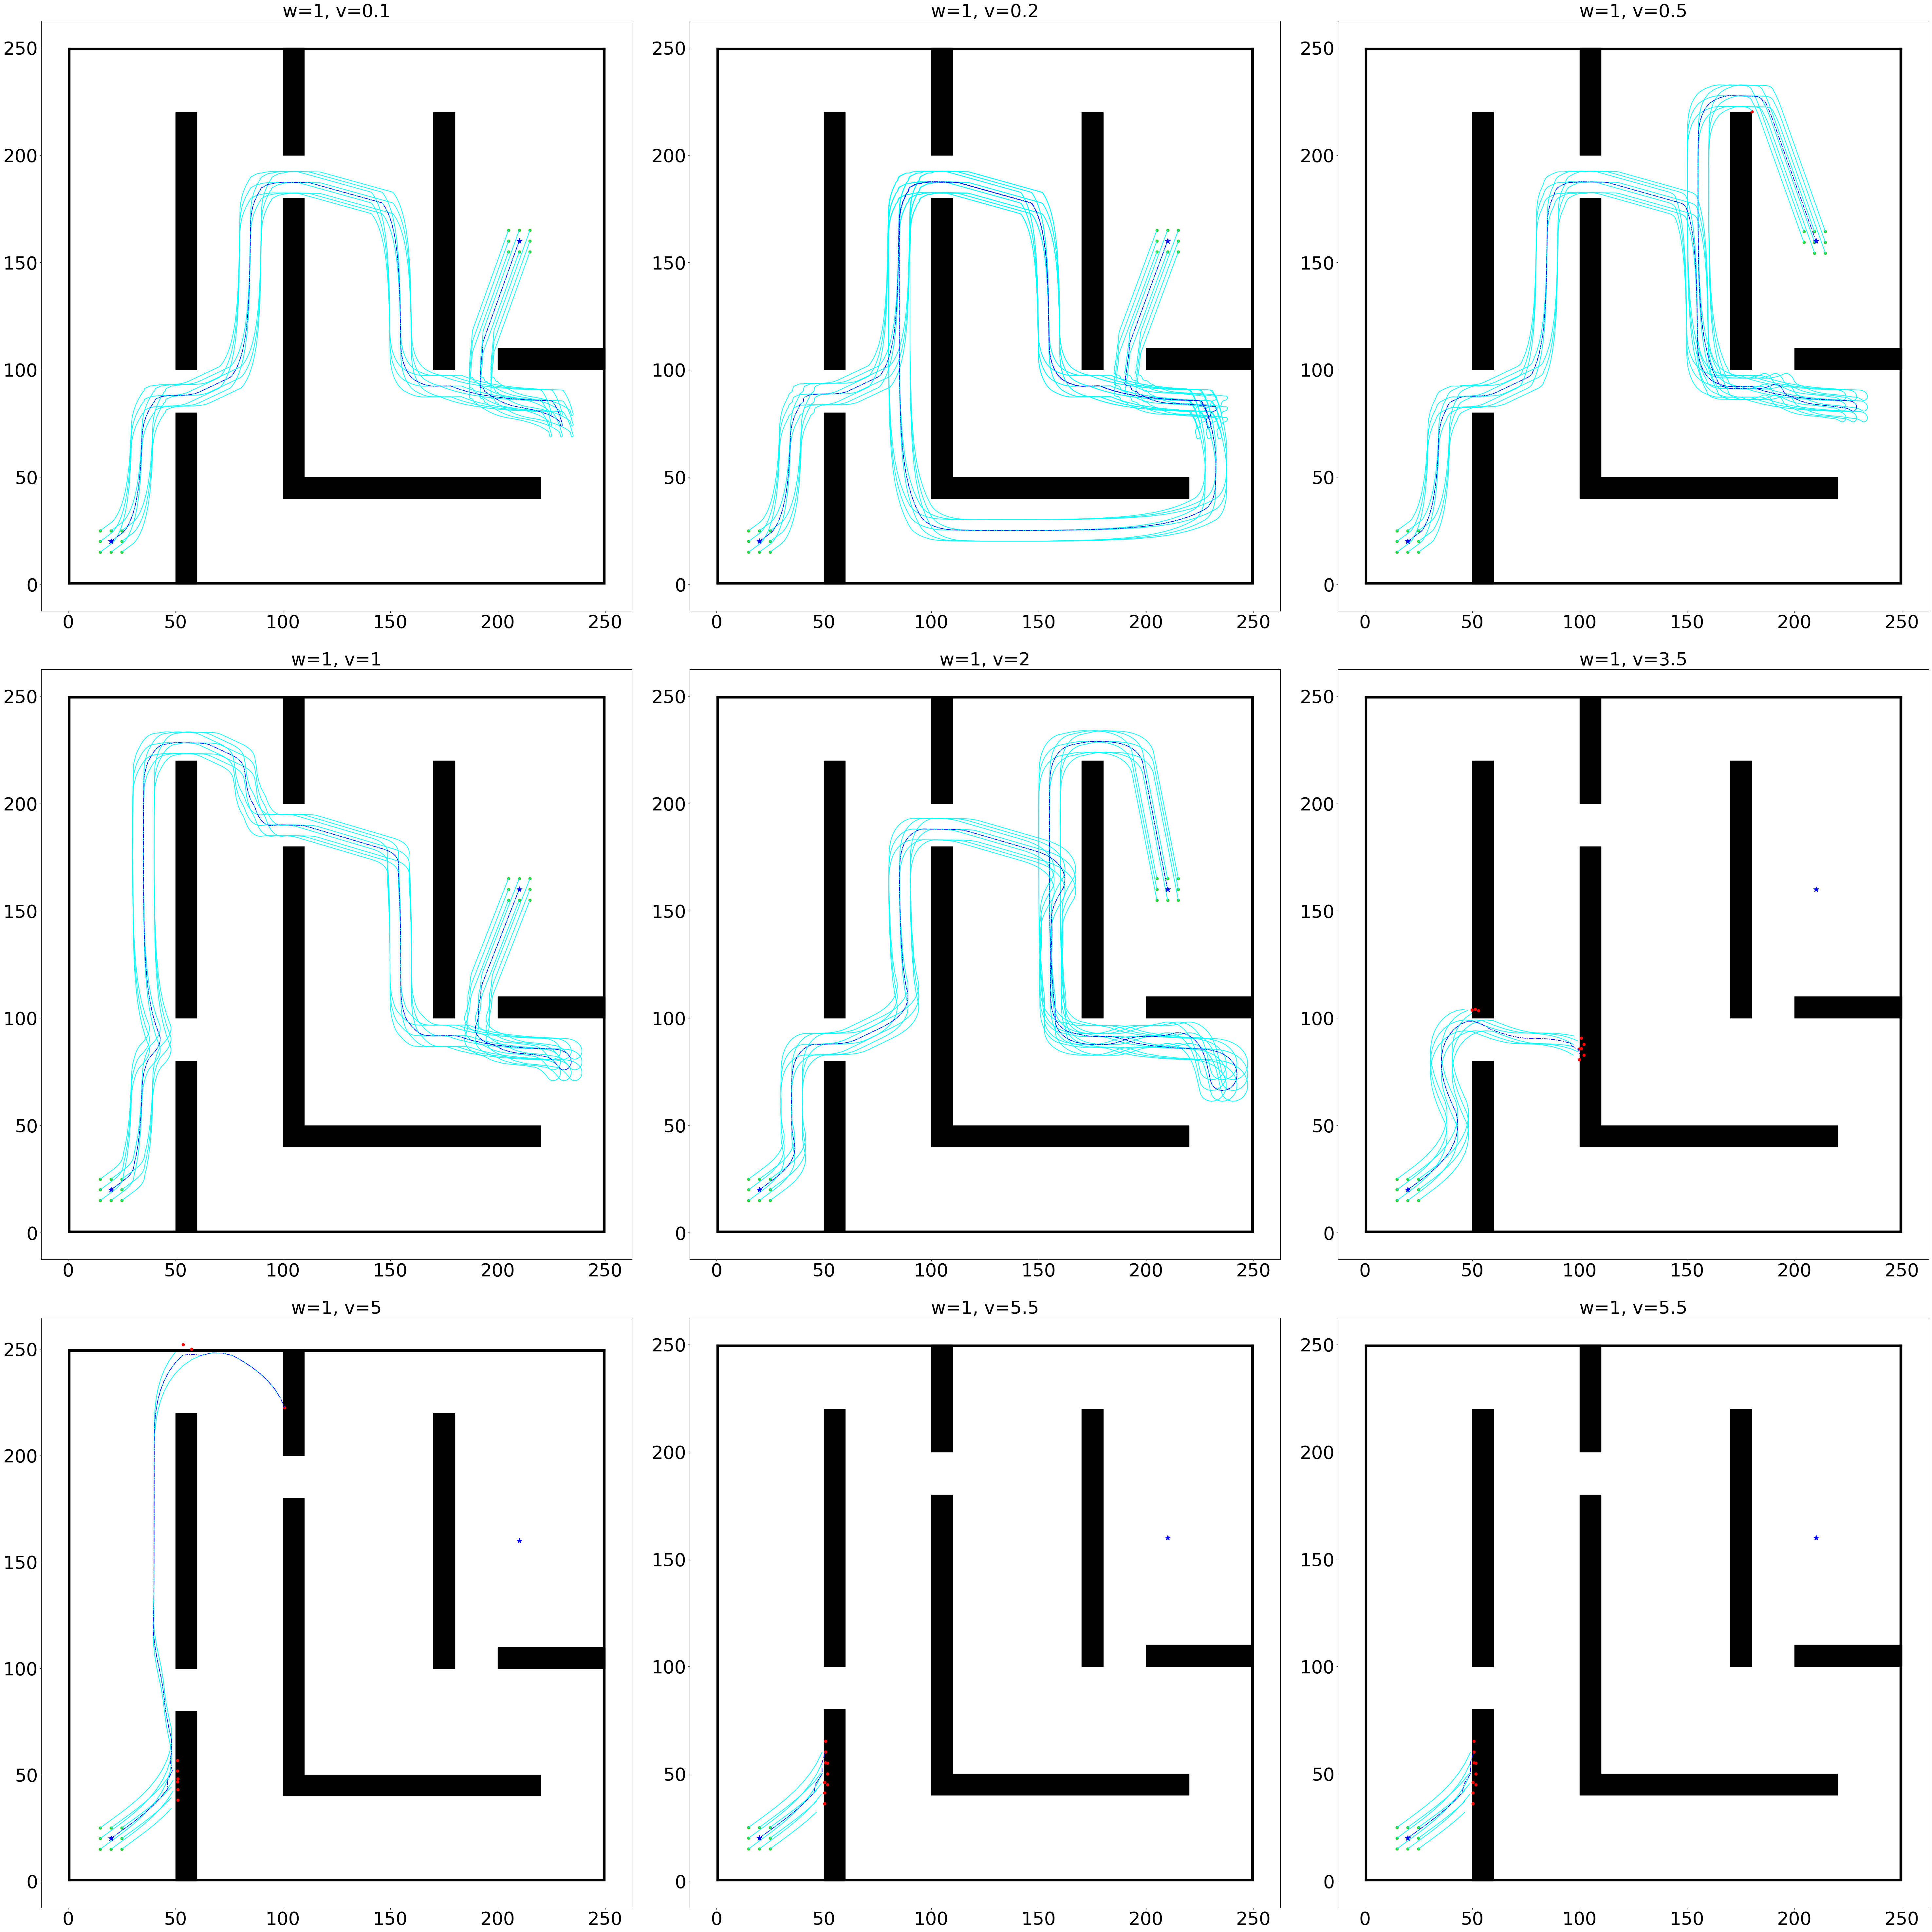

In [3]:
import matplotlib
%matplotlib inline
directory = '..\\..\\run_complex'
N = 3
sensor_range = 20
ROBOT_RADIUS = 0.3
Dx, Dy = desiredXYSquarePattern(N, 5)


#########################################################################################################################
# env = Env(250, 250, 125, 220, N * N, Dx, Dy, sensor_range, 125, 20, ROBOT_RADIUS, SENSOR_DETECTION_COUNT, 5000000)
# env.addObstacle(100, 70, 150, 100)
#
# env.addObstacle(50, 130, 100, 170)
# env.addObstacle(150, 130, 200, 170)
# ###########################################################################################################################
env = Env(250, 250, 210, 160, N * N, Dx, Dy, sensor_range, 20, 20, ROBOT_RADIUS, SENSOR_DETECTION_COUNT, 5000000)
    # env.addObstacle(50, 0, 60, 200)
env.addObstacle(50, 0, 60, 80)
env.addObstacle(50, 100, 60, 220)

env.addObstacle(100, 40, 220, 50)

env.addObstacle(100, 50, 110, 180)
env.addObstacle(100, 200, 110, 250)

env.addObstacle(170, 100, 180, 220)

env.addObstacle(200, 100, 250, 110)

#########################################################################################################################


w=1
matplotlib.rc('font', size=40)
fig, axs= pyplot.subplots(3, 3, figsize=(60, 60))#1 3 5 15 30 45
##############################################################################################################################################################
ax=axs[0, 0]
# ax.invert_yaxis()
v=0.1
ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

##############################################################################################################################################################
##############################################################################################################################################################
ax=axs[0, 1]
# ax.invert_yaxis()

v=0.2
env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
##############################################################################################################################################################
##############################################################################################################################################################
ax=axs[0, 2]
# ax.invert_yaxis()

v=0.5
env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
##############################################################################################################################################################
##############################################################################################################################################################
ax=axs[1, 0]
# ax.invert_yaxis()

v=1
env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
##############################################################################################################################################################
##############################################################################################################################################################
ax=axs[1, 1]
# ax.invert_yaxis()

v=2
env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
##############################################################################################################################################################
##############################################################################################################################################################
ax=axs[1, 2]
# ax.invert_yaxis()

v=3.5
env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
#############################################################################################################################################################


# ##############################################################################################################################################################
ax=axs[2, 0]
# ax.invert_yaxis()
v=5
ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')

env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

##############################################################################################################################################################
##############################################################################################################################################################
ax=axs[2, 1]
# ax.invert_yaxis()

v=5.5
env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
##############################################################################################################################################################
##############################################################################################################################################################
ax=axs[2, 2]
# ax.invert_yaxis()

v=5.5
env.reset()
while(not env.is_done):
    env.play_step(v,w*pi/180)
################################
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
line=[None]*env.N
for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')

ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
# ##############################################################################################################################################################
# ##############################################################################################################################################################
# ax=axs[3, 0]
# ax.invert_yaxis()
#
# v=5
# env.reset()
# while(not env.is_done):
#     env.play_step(v,w*pi/180)
# ################################
# posei=env.pose_history[:, env.N, :]
# ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
# line=[None]*env.N
# for i in range(env.N):
#                 posei=env.pose_history[:, i, :]
#                 deadi=env.dead_history[:, i]
#                 posei=posei[~deadi]
#                 ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
# for wall in env.walls:
#                 ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
# ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
# ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
# for agent in env.agents:
#                 ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
#                 ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')
#
# ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
# ##############################################################################################################################################################
# ##############################################################################################################################################################
# ax=axs[3, 1]
# ax.invert_yaxis()
#
# v=5.5
# env.reset()
# while(not env.is_done):
#     env.play_step(v,w*pi/180)
# ################################
# posei=env.pose_history[:, env.N, :]
# ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
# line=[None]*env.N
# for i in range(env.N):
#                 posei=env.pose_history[:, i, :]
#                 deadi=env.dead_history[:, i]
#                 posei=posei[~deadi]
#                 ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
# for wall in env.walls:
#                 ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
# ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
# ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
# for agent in env.agents:
#                 ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
#                 ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')
#
# ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
# ##############################################################################################################################################################
# ##############################################################################################################################################################
# ax=axs[3, 2]
# ax.invert_yaxis()
#
# v=6
# env.reset()
# while(not env.is_done):
#     env.play_step(v,w*pi/180)
# ################################
# posei=env.pose_history[:, env.N, :]
# ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)
# line=[None]*env.N
# for i in range(env.N):
#                 posei=env.pose_history[:, i, :]
#                 deadi=env.dead_history[:, i]
#                 posei=posei[~deadi]
#                 ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')
# for wall in env.walls:
#                 ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))
# ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
# ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
# for agent in env.agents:
#                 ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
#                 ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')
#
# ax.set_title('w='+str(w)+', v='+str(v),fontsize='medium')
##############################################################################################################################################################


fig.tight_layout()
fig.savefig( 'run.jpg', bbox_inches='tight')

pyplot.show()

In [39]:

axs[0, 0].plot(df_to_plot_t_.index, df_to_plot_t_[1], label='simple map')
axs[0, 0].plot(df_to_plot_t.index, df_to_plot_t[1], label='complex map')
axs[0, 0].legend()
axs[0, 0].set_title('w=1')
fig = pyplot.figure(figsize=(16, 16))
ax.invert_yaxis()
posei=env.pose_history[:, env.N, :]
ax.plot(posei[:env.t-1,0], posei[:env.t-1, 1], linestyle='dashdot',  label='Virtual Leader', color='blue', zorder=3)

line=[None]*env.N

for i in range(env.N):
                posei=env.pose_history[:, i, :]
                deadi=env.dead_history[:, i]
                posei=posei[~deadi]
                ax.plot(posei[:,0], posei[:, 1], label='Agent '+str(i), color='aqua')


            # ax.legend()
            for wall in env.walls:
                ax.add_patch(Rectangle((wall.from_x, wall.from_y), wall.length_x, wall.length_y, color='black'))

            ax.scatter(env.xL0, env.yL0, marker='*', zorder=3, color='blue', s=150)
            ax.scatter(env.xG, env.yG, marker='*', zorder=3, color='blue', s=150)
            for agent in env.agents:
                ax.scatter(env.xL0+agent.dx, env.yL0+agent.dy, color='limegreen')
                ax.scatter(env.pose_history[env.t-1, agent.id, 0], env.pose_history[env.t-1, agent.id, 1], color='red' if agent.is_dead else 'limegreen')
            fig.savefig(os.path.join(directory, 'run'+str(run)+'.jpg'), bbox_inches='tight')
            ax.clear()

IndentationError: unexpected indent (Temp/ipykernel_8332/536512555.py, line 6)

In [ ]:
df.loc[701]

In [ ]:
df.shape

In [ ]:
df_.shape

In [ ]:
df[df['w']==5]

In [3]:
N = 3
sensor_range = 20
ROBOT_RADIUS = 0.1
Dx, Dy = desiredXYSquarePattern(N, 5)
env = Env(250, 250, 210, 160, N * N, Dx, Dy, sensor_range, 20, 20, ROBOT_RADIUS, SENSOR_DETECTION_COUNT, 5000000)
    # env.addObstacle(50, 0, 60, 200)
env.addObstacle(50, 0, 60, 80)
env.addObstacle(50, 100, 60, 220)

env.addObstacle(100, 40, 220, 50)

env.addObstacle(100, 50, 110, 180)
env.addObstacle(100, 200, 110, 250)

env.addObstacle(170, 100, 180, 220)

env.addObstacle(200, 100, 250, 110)

episode_gui(env, 1, 1)

5.5
6.050000000000001
